## Use Kaggle API to download dataset

In [ ]:
from google.colab import files

!pip install -q kaggle

In [ ]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 102MB/s]
 73% 17.0M/23.4M [00:00<00:00, 49.2MB/s]
100% 23.4M/23.4M [00:00<00:00, 66.2MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 174MB/s]
 34% 9.00M/26.3M [00:00<00:00, 38.3MB/s]
100% 26.3M/26.3M [00:00<00:00, 75.3MB/s]


In [ ]:
!unzip -q train.csv.zip -d .
!unzip -q test.csv.zip -d .
!ls

kaggle.json  sample_submission.csv.zip	test.csv.zip	     train.csv
sample_data  test.csv			test_labels.csv.zip  train.csv.zip


In [ ]:
import os
os.chdir('/content/drive/MyDrive/CSC2515 Project Part 2') # move 'train.csv' to project folder (for perm. access)

In [ ]:
os.getcwd()

'/content/drive/MyDrive/CSC2515 Project Part 2'

## Import and preview data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('train.csv')
#df2 = pd.read_csv('test.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.shape

In [ ]:
df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [ ]:
len(df.id.unique()) # each comment posted by a *unique* user

159571

In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

## Brief cleaning

In [ ]:
df.isnull().sum() # no missing values

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
df[df.duplicated()] # no duplicate comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


## Summary statistics

In [ ]:
total_clean = (df.iloc[:,2:].sum(axis = 1) == 0).sum()

In [ ]:
print('There is a total of {} comments'.format(len(df)))
print('Out of which theere are {} clean comments,'.format(total_clean)) # clean = non-toxic
print('which is {} percent of the total number of comments'.format(round(total_clean/len(df) * 100, 2)))
print('so toxic comments only make up {} percent'.format(round((1 - total_clean/len(df)) * 100, 2)))

There is a total of 159571 comments
Out of which theere are 143346 clean comments,
which is 89.83 percent of the total number of comments
so toxic comments only make up 10.17 percent


In [ ]:
total_toxic_labels = df.iloc[:,2:].sum().sum()
print('There are a total of {} toxicity labels.'.format(total_toxic_labels))

There are a total of 35098 toxicity labels.


In [ ]:
total_clean + total_toxic_labels > len(df)

True

Since sum of total number of toxicity labels and clean comments exceed the total, this implies there are comments with > 1 labels associated (e.g. a comment can be both `threat` and `identity_hate`.

## EDA

Non-toxic, or `clean` comments take up an overwhelming 80.33% of all training sample comments. Category `toxic` comments make up 8.57% of the total number of toxic comments, much higher than the 5 other categories of toxicity labels. So we have an imbalanced data distribution - need to consider techniques like undersampling/oversampling/ SMOTE, and stratified k-fold CV/ train-test split.

In [ ]:
orig_rowsum = df.iloc[:,2:].sum(axis=1) # save original rowsums before creating 'clean' column

In [ ]:
df['clean']=(df.iloc[:,2:].sum(axis=1)==0) # make new column to label non-toxic (or clean) comments

In [ ]:
num_toxic_all = df.iloc[:,2:].sum()
round((num_toxic_all / num_toxic_all.sum()) * 100, 2)

toxic             8.57
severe_toxic      0.89
obscene           4.73
threat            0.27
insult            4.41
identity_hate     0.79
clean            80.33
dtype: float64

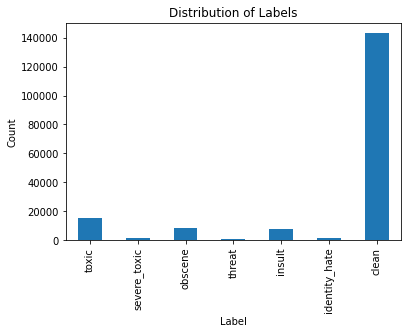

In [ ]:
plt1 = num_toxic_all.plot.bar()
plt1.set_xlabel('Label'); plt1.set_ylabel('Count')
plt1.set_title('Distribution of Labels')
plt1.figure.savefig('Labels.png')

Comments with 1 label takes up 4.0%, and with 3 labels take up 2.6%. Not surprisingly, comments with 0 toxicity labels (i.e. non-toxic comments) take up the most, 89.8%.

In [ ]:
num_labels = orig_rowsum.value_counts()
round((num_labels / num_labels.sum()) * 100, 2)

0    89.83
1     3.99
3     2.64
2     2.18
4     1.10
5     0.24
6     0.02
dtype: float64

Look at some example comments from each toxicity category to get a feel of what to clean. 

In [ ]:
print('~~~Example of TOXIC comment:~~~')
print(df[df.toxic == 1].iloc[1,1]); print()
print('~~~Example of SEVERE_TOXIC comment:~~~')
print(df[df.severe_toxic == 1].iloc[1,1]); print()
print('~~~Example of OBSCENE comment:~~~')
print(df[df.obscene == 1].iloc[1,1]); print()
print('~~~Example of THREAT comment:~~~')
print(df[df.threat == 1].iloc[1,1]); print()
print('~~~Example of INSULT comment:~~~')
print(df[df.insult == 1].iloc[2,1]); print()
print('~~~Example of IDENTITY_HATE comment:~~~')
print(df[df.identity_hate == 1].iloc[1,1]); print()
print('~~~Example of CLEAN comment:~~~')
print(df[df.clean == 1].iloc[1,1]); print()

~~~Example of TOXIC comment:~~~
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...

~~~Example of SEVERE_TOXIC comment:~~~
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!

~~~Example of OBSCENE comment:~~~
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First 

In [ ]:
all_words = df['comment_text'].str.split(expand=True).unstack().value_counts()

In [ ]:
all_words.index.values[0:10] # top 10 (uncleaned) words

array(['the', 'to', 'of', 'and', 'a', 'I', 'is', 'you', 'that', 'in'],
      dtype=object)

### word cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
#! pip install nltk

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = set(stopwords.words("english"))

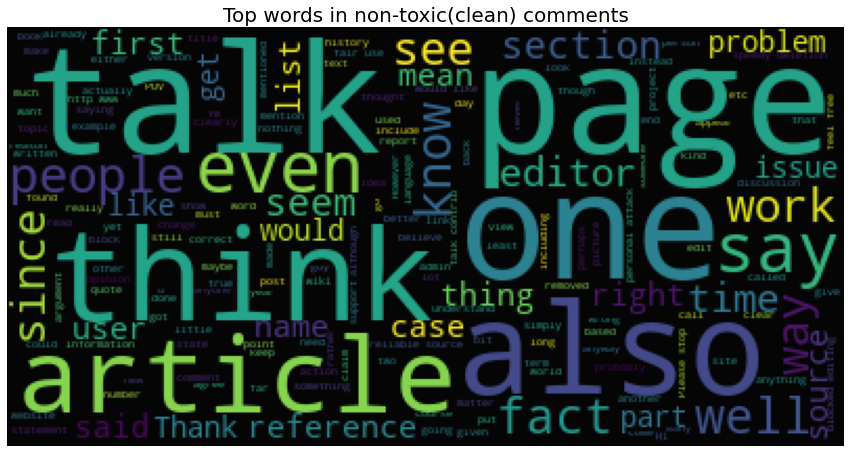

In [ ]:
# non-toxic comments word cloud
comment_clean = df[df.clean==1]['comment_text'].values
wc= WordCloud(background_color="black",max_words=1000,stopwords=stop_words)
wc_token = wc.generate(" ".join(comment_clean))
plt.figure(figsize=(15,8))
plt.axis("off")
plt.title("Top words in non-toxic(clean) comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=50), alpha=0.98)
plt.show()
wc_token.to_file('wordcloud_clean.png')

Ignore below

In [ ]:
#321,322,323, 324,325

In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/CSC2515 Project Part 2'

In [ ]:
df.columns


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean'],
      dtype='object')

In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean'],
      dtype='object')

In [ ]:
df[df.threat == 1]['comment_text'].iloc[400]

'Mmmm... yes... a pint of palestinian blood would be a fine dessert right now. -  talk/email'

In [ ]:
# '\n','\nll', "", timezone (e.g. ' (talk) 21:51, January 11, 2016 (UTC)')

In [ ]:
#df[df.obscene == 1]
df.iloc[159541:159543,:]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159542,ffa95244f261527f,maybe he's got better things to do than spend ...,0,0,0,0,0,0
